In [3]:
import pandas as pd
import numpy as np
import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["lines.linewidth"] = 1.0
plt.rcParams["font.size"] = 6.0
plt.rcParams["axes.titlesize"] = 6.0

In [2]:
# Define helper functions.
def scatter_hist(x, y, ax, ax_histx, ax_histy, color=plt.cm.viridis(0.25)):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, marker=".", color=color, s=4, edgecolor=None, alpha=1.0)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=100, color=color, alpha=0.6, density=True)
    ax_histy.hist(y, bins=100, orientation='horizontal', color=color, alpha=0.6, density=True)

In [3]:
data = pd.read_excel("data.xlsx", index_col=0)
mean_data = data.groupby(by="CO-ref / ppb").mean()
x, y = mean_data["CO-B4 / V"].values, mean_data.index.values
mean_data.head()

,CO-B4 / V
CO-ref / ppb,
100,0.089560
200,0.106705
400,0.148126
800,0.232793


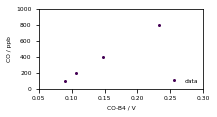

In [4]:
fig = plt.figure(figsize=(2.95,0.5*2.95))
plt.plot(x, y, ".", ms=4, color=plt.cm.viridis(0.00), label="data")
plt.ylim(0, 1000)
plt.ylabel("CO / ppb")
plt.xlim(0.05, 0.30)
plt.xlabel("CO-B4 / V")
plt.legend(loc=4, frameon=False)
plt.show()

In [5]:
# Define model.
with pm.Model() as linear_model:
    
    # Define priors.
    slope = pm.Normal("slope", mu=2450, sigma=550)
    intercept = pm.Normal("intercept", mu=35, sigma=45)
    
    # Define posterior.
    y_obs = pm.Normal("CO-ref",
            mu=x * slope + intercept,
            observed=y)
    
    # Sample.
    prior = pm.sample_prior_predictive()
    posterior = pm.sample(2000, tune=2000, init="adapt_diag")

/Users/gtancev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  from ipykernel import kernelapp as app
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8840125873663308, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8832032825339684, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


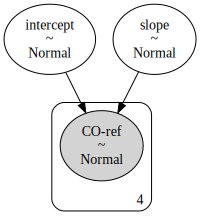

In [9]:
# Visualize graphical model.
pm.model_graph.model_to_graphviz(linear_model)

In [6]:
pm.summary(posterior, hdi_prob=0.94)

/Users/gtancev/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
slope,4839.204,9.297,4821.704,4856.082,0.249,0.176,1390.0,1390.0,1385.0,1668.0,1.0
intercept,-323.233,1.441,-325.902,-320.502,0.039,0.027,1400.0,1399.0,1398.0,1635.0,1.0


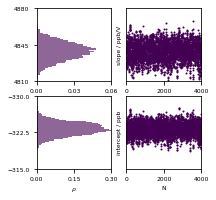

In [14]:
# Plot traces.
n_v = len(posterior.varnames)
units = [" / ppb/V", " / ppb"]
limits_x = [(0.0, 0.06), (0.0, 0.3)]
limits_y = [(4810, 4880), (-315, -330)] 
labels = ["", "", ""]
fig, axes = plt.subplots(figsize=(2.95, 0.5*n_v*2.95), ncols=2, nrows=n_v)
ax = axes.ravel()
for k in range(n_v):
    ax[2*k].hist(posterior[posterior.varnames[k]], orientation="horizontal", density=True, bins=50, color=plt.cm.viridis(0.00), alpha=0.6)
    ax[2*k+1].plot(posterior[posterior.varnames[k]], ".", ms=2, color=plt.cm.viridis(0.00), alpha=1.0)
    ax[2*k+1].set_ylabel(posterior.varnames[k].lower()+units[k])
    ax[2*k+1].set_yticks(())
    ax[2*k+1].set_xlim((0, 4000))
    ax[2*k+1].set_xticks((0, 2000, 4000))
    ax[2*k].set_xlim(limits_x[k])
    ax[2*k].set_xticks(np.linspace(limits_x[k][0], limits_x[k][1], 3))
    ax[2*k].set_ylim(limits_y[k])
    ax[2*k].set_yticks(np.linspace(limits_y[k][0], limits_y[k][1], 3))
    ax[2*k+1].set_ylim(limits_y[k])
    #ax[2*k].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[2*k].set_xlabel(r"$\rho$")
ax[2*k+1].set_xlabel(r"N")
plt.savefig('./figures/parameter_sampling',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

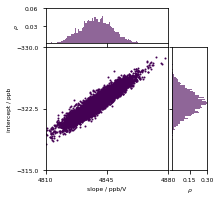

In [9]:
# Plot parameter distribution.
units = [" / ppb/V", " / ppb"]
fig = plt.figure(figsize=(0.95*2.95, 0.95*2.95))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax.set_xlim(4810, 4880)
ax.set_ylim(-315, -330)
ax.set_xlabel(posterior.varnames[0].lower()+units[0])
ax.set_ylabel(posterior.varnames[1].lower()+units[1])

ax.set_yticks((-330, -322.5, -315))
ax.set_xticks((4810, 4845, 4880))

ax_histx.set_ylim(0, 0.06)
ax_histx.set_yticks((0.03, 0.06))
ax_histx.set_ylabel(r"$\rho$")

ax_histy.set_xlim(0.0, 0.3)
ax_histy.set_xticks((0.15, 0.3))
ax_histy.set_xlabel(r"$\rho$")

scatter_hist(posterior[posterior.varnames[0]], posterior[posterior.varnames[1]], ax, ax_histx, ax_histy, color=plt.cm.viridis(0.00))
plt.savefig('./figures/parameter_scatter',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

/Users/gtancev/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


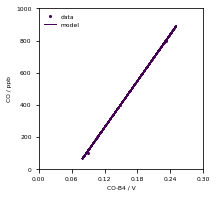

In [8]:
# Plot predictions (with uncertainty).
def linear_model(posterior, x):
    return posterior["slope"] * x + posterior["intercept"]

lm = lambda x, samples: linear_model(samples, x)

plt.figure(figsize=(2.95, 2.95))
plt.plot(x, y, ".", ms=4, color=plt.cm.viridis(0.0), label="data")
pm.plot_posterior_predictive_glm(posterior, eval=np.linspace(0.08, 0.25, 500), 
                                 lm=lm, samples=1000, lw=1, color=plt.cm.viridis(0.00), alpha=1.0, label="model")
plt.title(label=None)
plt.xlabel(r"CO-B4 / V")
plt.ylabel(r"CO / ppb")
plt.xlim((0.00, 0.3))
plt.xticks(np.linspace(0.00, 0.3, 6))
plt.ylim((0, 1000))
plt.yticks(np.linspace(0.0, 1000, 6))
plt.legend(frameon=False, loc=2)
plt.savefig('./figures/prediction', dpi=900, transparent=True, orientation='landscape', bbox_inches='tight')
plt.show()

The mean is 644.6
The standard deviation is 0.7
The 94% credible interval is between 643.3 646.0
The mean is 2580.3
The standard deviation is 4.3
The 94% credible interval is between 2572.4 2588.1


/Users/gtancev/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:341: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


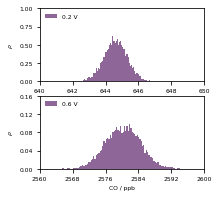

In [9]:
# Plot posterior predictive distributions.

x_1 = 0.20
y_1 = linear_model(posterior, x_1)
print("The mean is", np.round(np.mean(y_1), 1))
print("The standard deviation is", np.round(np.std(y_1), 1))
print("The 94% credible interval is between", *np.round(pm.stats.hpd(y_1, credible_interval=0.94), 1))

x_2 = 0.60
y_2 = linear_model(posterior, x_2)
print("The mean is", np.round(np.mean(y_2), 1))
print("The standard deviation is", np.round(np.std(y_2), 1))
print("The 94% credible interval is between", *np.round(pm.stats.hpd(y_2, credible_interval=0.94), 1))

fig, axes = plt.subplots(figsize=(2.95, 2.95), ncols=1, nrows=2)
ax = axes.ravel()
ax[0].hist(y_1, bins=100, density=True, color=plt.cm.viridis(0.00), alpha=0.6, label="0.2 V")
ax[0].set_xlim(640, 650)
ax[0].set_xticks(np.linspace(640, 650, 6))
ax[0].set_ylim(0, 1)
ax[0].set_yticks(np.linspace(0, 1, 5))
ax[0].set_ylabel(r"$\rho$")
ax[0].legend(frameon=False, loc=2)
ax[1].hist(y_2, bins=100, density=True, color=plt.cm.viridis(0.00), alpha=0.6, label="0.6 V")
ax[1].set_xlim(2560, 2600)
ax[1].set_xticks(np.linspace(2560, 2600, 6))
ax[1].set_ylim(0, 0.16)
ax[1].set_yticks(np.linspace(0, 0.16, 5))
ax[1].set_xlabel(r"CO / ppb")
ax[1].set_ylabel(r"$\rho$")
ax[1].legend(frameon=False, loc=2)
plt.savefig('./figures/prediction_new_samples',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [10]:
# Define model.
with pm.Model() as variational_linear_model:
    
    # Define priors.
    slope = pm.Normal("slope", mu=2450, sigma=550)
    intercept = pm.Normal("intercept", mu=35, sigma=45)
    
    # Define posterior.
    y_obs = pm.Normal("CO-ref",
            mu=x * slope + intercept,
            observed=y)
    
    # Sample.
    approx = pm.fit(n=int(1e7), method="advi")

Finished [100%]: Average Loss = 155.75


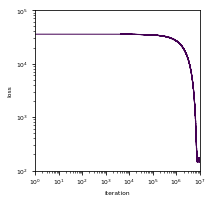

In [7]:
# Plot the training session.
fig = plt.figure(figsize=(2.95, 2.95))
fig.tight_layout()
plt.yscale("log")
plt.xscale("log")
plt.xlim(1, len(approx.hist))
plt.ylim(1e2, 1e5)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(approx.hist, color=plt.cm.viridis(0.00))
plt.savefig('./figures/loss_LM_ADVI',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [11]:
# Sample from the posterior.
approx_posterior = approx.sample(4000)
pm.summary(approx_posterior, hdi_prob=0.94)

/Users/gtancev/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
slope,4838.960,3.511,4832.303,4845.241,0.056,0.040,3892.0,3892.0,3894.0,3848.0,NaN
intercept,-323.181,0.562,-324.295,-322.162,0.009,0.006,3980.0,3980.0,3978.0,3493.0,NaN


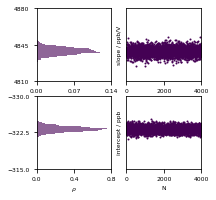

In [12]:
# Plot traces.
n_v = len(approx_posterior.varnames)
units = [" / ppb/V", " / ppb"]
limits_x = [(0.0, 0.14), (0.0, 0.8)]
limits_y = [(4810, 4880), (-315, -330)] 
labels = ["", "", ""]
fig, axes = plt.subplots(figsize=(2.95, 0.5*n_v*2.95), ncols=2, nrows=n_v)
ax = axes.ravel()
for k in range(n_v):
    ax[2*k].hist(approx_posterior[approx_posterior.varnames[k]], orientation="horizontal", density=True, bins=50, color=plt.cm.viridis(0.00), alpha=0.6)
    ax[2*k+1].plot(approx_posterior[approx_posterior.varnames[k]], ".", ms=2, color=plt.cm.viridis(0.00), alpha=1.0)
    ax[2*k+1].set_ylabel(approx_posterior.varnames[k].lower()+units[k])
    ax[2*k+1].set_yticks(())
    ax[2*k+1].set_xlim((0, 4000))
    ax[2*k+1].set_xticks((0, 2000, 4000))
    ax[2*k].set_xlim(limits_x[k])
    ax[2*k].set_xticks(np.linspace(limits_x[k][0], limits_x[k][1], 3))
    ax[2*k].set_ylim(limits_y[k])
    ax[2*k].set_yticks(np.linspace(limits_y[k][0], limits_y[k][1], 3))
    ax[2*k+1].set_ylim(limits_y[k])
    #ax[2*k].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[2*k].set_xlabel(r"$\rho$")
ax[2*k+1].set_xlabel(r"N")
plt.savefig('./figures/parameter_sampling_ADVI',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

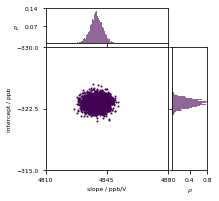

In [12]:
# Plot parameter distribution.
units = [" / ppb/V", " / ppb"]
fig = plt.figure(figsize=(0.95*2.95, 0.95*2.95))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax.set_xlim(4810, 4880)
ax.set_ylim(-315, -330)
ax.set_xlabel(approx_posterior.varnames[0].lower()+units[0])
ax.set_ylabel(approx_posterior.varnames[1].lower()+units[1])

ax.set_yticks((-330, -322.5, -315))
ax.set_xticks((4810, 4845, 4880))

ax_histx.set_ylim(0, 0.14)
ax_histx.set_yticks((0.07, 0.14))
ax_histx.set_ylabel(r"$\rho$")

ax_histy.set_xlim(0.0, 0.8)
ax_histy.set_xticks((0.4, 0.8))
ax_histy.set_xlabel(r"$\rho$")

scatter_hist(approx_posterior[approx_posterior.varnames[0]], 
             approx_posterior[approx_posterior.varnames[1]], 
             ax, ax_histx, ax_histy, color=plt.cm.viridis(0.00))
plt.savefig('./figures/parameter_scatter_ADVI',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

/Users/gtancev/opt/anaconda3/lib/python3.7/site-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


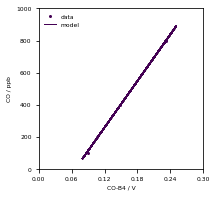

In [12]:
# Plot predictions (with uncertainty).
def linear_model_ADVI(approx_posterior, x):
    return approx_posterior["slope"] * x + approx_posterior["intercept"]

lm_ADVI = lambda x, samples: linear_model_ADVI(samples, x)

plt.figure(figsize=(2.95, 2.95))
plt.plot(x, y, ".", ms=4, color=plt.cm.viridis(0.00), label="data")
pm.plot_posterior_predictive_glm(approx_posterior, eval=np.linspace(0.08, 0.25, 500), 
                                 lm=lm_ADVI, samples=1000, lw=1, color=plt.cm.viridis(0.00), alpha=1.0, label="model")
plt.title(label=None)
plt.xlabel(r"CO-B4 / V")
plt.ylabel(r"CO / ppb")
plt.xlim((0.00, 0.3))
plt.xticks(np.linspace(0.00, 0.3, 6))
plt.ylim((0, 1000))
plt.yticks(np.linspace(0.0, 1000, 6))
plt.legend(frameon=False, loc=2)
plt.savefig('./figures/prediction_ADVI', dpi=900, transparent=True, orientation='landscape', bbox_inches='tight')
plt.show()

The mean is 644.6
The standard deviation is 0.9
The 94% credible interval is between 643.0 646.4
The mean is 2580.2
The standard deviation is 2.2
The 94% credible interval is between 2576.2 2584.3


/Users/gtancev/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:341: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


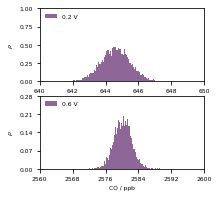

In [13]:
# Plot posterior predictive distributions.

x_1 = 0.20
y_1 = linear_model_ADVI(approx_posterior, x_1)
print("The mean is", np.round(np.mean(y_1), 1))
print("The standard deviation is", np.round(np.std(y_1), 1))
print("The 94% credible interval is between", *np.round(pm.stats.hpd(y_1, credible_interval=0.94), 1))

x_2 = 0.60
y_2 = linear_model_ADVI(approx_posterior, x_2)
print("The mean is", np.round(np.mean(y_2), 1))
print("The standard deviation is", np.round(np.std(y_2), 1))
print("The 94% credible interval is between", *np.round(pm.stats.hpd(y_2, credible_interval=0.94), 1))

fig, axes = plt.subplots(figsize=(2.95, 2.95), ncols=1, nrows=2)
ax = axes.ravel()
ax[0].hist(y_1, bins=100, density=True, color=plt.cm.viridis(0.00), alpha=0.6, label="0.2 V")
ax[0].set_xlim(640, 650)
ax[0].set_xticks(np.linspace(640, 650, 6))
ax[0].set_ylim(0, 1)
ax[0].set_yticks(np.linspace(0, 1, 5))
ax[0].set_ylabel(r"$\rho$")
ax[0].legend(frameon=False, loc=2)
ax[1].hist(y_2, bins=100, density=True, color=plt.cm.viridis(0.00), alpha=0.6, label="0.6 V")
ax[1].set_xlim(2560, 2600)
ax[1].set_xticks(np.linspace(2560, 2600, 6))
ax[1].set_ylim(0, 0.28)
ax[1].set_yticks(np.linspace(0, 0.28, 5))
ax[1].set_xlabel(r"CO / ppb")
ax[1].set_ylabel(r"$\rho$")
ax[1].legend(frameon=False, loc=2)
plt.savefig('./figures/prediction_new_samples_ADVI',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()